# Process the output of the simulation

(This can be required if the sensitivity curve does not form a single connected (but possibly open) path.)

List the currently-installed packages (for reproducibility).

In [1]:
]st

Status `~/Documents/Research/Projects/SensCalc/Code/SensMC/Project.toml`
⌃ [336ed68f] CSV v0.10.8
⌃ [a93c6f00] DataFrames v1.4.4
  [864edb3b] DataStructures v0.18.13
⌃ [31c24e10] Distributions v0.25.86
⌃ [e9467ef8] GLMakie v0.8.2
⌃ [5c1252a2] GeometryBasics v0.4.6
  [7073ff75] IJulia v1.24.0
⌃ [682c06a0] JSON v0.21.3
  [3f54b04b] LorentzVectors v0.4.3
  [ea0cff06] MDBM v0.1.6 `https://github.com/JLTastet/MDBM.jl#3788144`
⌅ [ee78f7c6] Makie v0.19.2
  [c03570c3] Memoize v0.4.4
  [e1d29d7a] Missings v1.1.0
  [3b2b4ff1] Multisets v0.4.4
⌃ [bac558e1] OrderedCollections v1.4.1
  [c46f51b8] ProfileView v1.7.1
  [438e738f] PyCall v1.95.1
  [d330b81b] PyPlot v2.11.1
⌃ [f2b01f46] Roots v2.0.10
⌃ [90137ffa] StaticArrays v1.5.18
⌅ [2913bbd2] StatsBase v0.33.21
  [8ba89e20] Distributed
  [37e2e46d] LinearAlgebra
  [1a1011a3] SharedArrays
Info Packages marked with ⌃ and ⌅ have new versions available, but those with ⌅ are restricted by compatibility constraints from upgrading. To see why use `status 

Include the snapshots of the relevant scripts (once again for reproducibility).

In [2]:
include("$(@__DIR__)/../lib/IncludeAll.jl");
include("$(@__DIR__)/../scripts/GenerateEvents.jl");
include("$(@__DIR__)/../scripts/ScanSensitivity.jl");

  Activating project at `~/Documents/Research/Projects/SensCalc/Code/SensMC`


In [3]:
data_dir = "$(@__DIR__)/../tables/sensitivity/SHADOWS";

In [4]:
using DataFrames
using CSV
using Printf
using PyPlot
PyPlot.svg(true)
using Random
Random.seed!(12903);

In [5]:
function read_sensitivity(root, name)
    df_sol = CSV.read(joinpath(root, "$(name).csv"), DataFrame)
    df_ct  = CSV.read(joinpath(root, "$(name)_connection.csv"), DataFrame)
    edges = tuple.(df_ct[:,1], df_ct[:,2]);
    open_loops, closed_loops = find_loops(edges)
    curves = [(df_sol[perm,1], df_sol[perm,2]) for perm in vcat(open_loops, closed_loops)]
end

read_sensitivity (generic function with 1 method)

Plot the sensitivity along with the one obtained by Maksym, as a last cross-check.

In [6]:
function make_plot(; title="", xlabel=L"m_S\;[\mathrm{GeV}]", ylabel=L"\theta^2", figsize=(6.4, 4.8), grid=true)
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_yscale("log")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel);
    if grid
        ax.grid(color="gray", linestyle=":")
    end
    ax.autoscale()
    ax.set_title(title, fontsize=10)
    fig, ax
end

make_plot (generic function with 1 method)

In [7]:
function plot_sensitivity!(ax, root, name; label="", square=false, style...)
    curves = read_sensitivity(root, name)
    xs, ys = [], []
    for (i, curve) in enumerate(curves)
        lb = if i == 1; label else; "" end
        x, y = curve
        y = square ? y .^2 : y
        ax.plot(x, y, label=lb; style...)
        push!(xs, x)
        push!(ys, y)
    end
    xs, ys
end

plot_sensitivity! (generic function with 1 method)

In [8]:
function plot_reference_sensitivity!(ax, root, name;
        header=["mS", "signal_scale"], square=false, linewidth=1, style...)
    df = CSV.read(joinpath(root, name), DataFrame, header=header)
    y = square ? df[:,2] .^2 : df[:,2]
    ax.plot(df[:,1], y; linewidth=linewidth, style...)
end

plot_reference_sensitivity! (generic function with 1 method)

In [9]:
function plot_excluded_region!(ax, root, name;
        header=["mS", "signal_scale"], square=false, linewidth=1, style...)
    df = CSV.read(joinpath(root, name), DataFrame, header=header)
    y = square ? df[:,2] .^2 : df[:,2]
    ax.plot(df[:,1], y; color="black", linewidth=linewidth, style...)
    ax.fill(df[:,1], y; color="lightgrey", style...)
end

plot_excluded_region! (generic function with 1 method)

#### Produce the plot for the paper

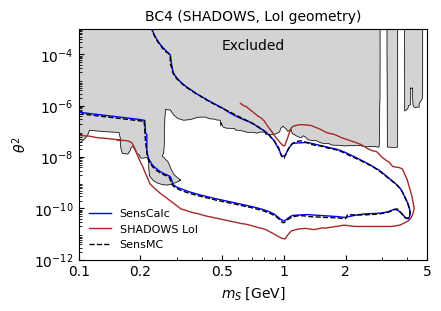

In [10]:
fig, ax = make_plot(title="BC4 (SHADOWS, LoI geometry)", figsize=(4.5,3), grid=false)
plot_excluded_region!(ax, joinpath(data_dir, ".."), "scalar-all-experiments.txt"; header=["mS", "theta"], linewidth=0.5)
plot_reference_sensitivity!(ax, data_dir, "Sensitivity_Scalar_at_SHADOWS-LoI_BrhToSS=0._Nev=2.3.dat"; header=["mS", "theta"], label="SensCalc", color="blue")
plot_reference_sensitivity!(ax, data_dir, "BC4-sensitivity-SHADOWS.txt"; header=["mS", "theta"], label="SHADOWS LoI", color="brown")
mS, θ² = plot_sensitivity!(ax, data_dir, "SHADOWS_scalar_sensitivity_CL90", label="SensMC", color="black", linestyle="--", square=true, linewidth=1)
ax.set_xscale("log")
ax.autoscale()
ax.set_xlim(left=0.1, right=5)
ax.set_ylim(top=1e-3, bottom=1e-12)
xticks = [0.1, 0.2, 0.5, 1, 2, 5]
ax.set_xticks(xticks)
ax.set_xticklabels([@sprintf("%.1g", x) for x in xticks])
ax.legend(loc="lower left", frameon=false, fontsize=8)
ax.yaxis.set_minor_locator(matplotlib.ticker.LogLocator(numticks=999, subs="auto"))
ax.tick_params(axis="both", which="both", direction="in")
#ax.text(0.83, 0.61, "CL = 0.9", fontsize=15, transform=ax.transAxes, ha="center", va="top")
ax.text(0.5, 0.96, "Excluded", fontsize=10, transform=ax.transAxes, ha="center", va="top")
nothing

In [11]:
fig.savefig("$(@__DIR__)/../plots/SHADOWS_scalar_sensitivity_CL90.pdf", bbox_inches="tight")

#### Process and save the actual sensitivity curve

Extract the relevant loop(s).

In [12]:
mS

1-element Vector{Any}:
 [0.21469972505073268, 0.21501955090244423, 0.21661768251608857, 0.21789296839630404, 0.21900248932637442, 0.21920432896484696, 0.22035744989096703, 0.22191736735222012, 0.22342899690804824, 0.22473992909984167  …  0.12142362178304421, 0.11899303520446931, 0.11882012893370958, 0.1164445239129686, 0.11410188392103918, 0.11181051608561493, 0.10956583388435373, 0.10736676132851186, 0.10521034159098998, 0.10309745621127248]

The array looks well connected, so let’s save it without further processing.

In [13]:
@assert length(mS) == 1
@assert length(θ²) == 1

In [14]:
mS[1]

451-element Vector{Float64}:
 0.21469972505073268
 0.21501955090244423
 0.21661768251608857
 0.21789296839630404
 0.21900248932637442
 0.21920432896484696
 0.22035744989096703
 0.22191736735222012
 0.22342899690804824
 0.22473992909984167
 0.22629684294335867
 0.22824259538917352
 0.23023137893649537
 ⋮
 0.12645365897773753
 0.12391109149780222
 0.12142362178304421
 0.11899303520446931
 0.11882012893370958
 0.1164445239129686
 0.11410188392103918
 0.11181051608561493
 0.10956583388435373
 0.10736676132851186
 0.10521034159098998
 0.10309745621127248

Create a data frame containing the curve (reversed, to keep the direction consistent with the other curves).

In [15]:
df = DataFrame(mS = reverse(mS[1]), theta2 = reverse(θ²[1]))

Row,mS,theta2
,Float64,Float64
1,0.103097,4.81377e-7
2,0.10521,4.71981e-7
3,0.107367,4.63237e-7
4,0.109566,4.54417e-7
5,0.111811,4.45493e-7
6,0.114102,4.36782e-7
7,0.116445,4.28756e-7
8,0.11882,4.2025e-7
9,0.118993,4.19623e-7


Let’s check that it plots correctly.

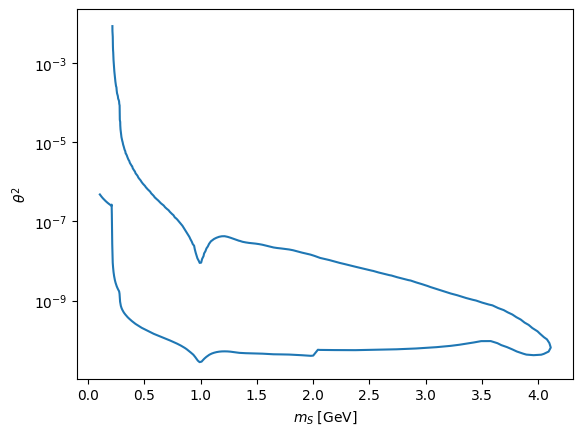

In [16]:
plt.plot(df.mS, df.theta2)
plt.yscale("log")
plt.xlabel(raw"$m_S\;[\mathrm{GeV}]$")
plt.ylabel(raw"$\theta^2$");

Looks good. Let’s save the final curve.

In [17]:
CSV.write(joinpath(data_dir, "SHADOWS_scalar_sensitivity_curve_CL90.csv"), df)

"/Users/jl/Documents/Research/Projects/SensCalc/Code/SensMC/notebooks/../tables/sensitivity/SHADOWS/SHADOWS_scalar_sensitivity_curve_CL90.csv"